______________________

In [65]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
#from keras_vggface.vggface import VGGFace
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator

### DATASET CREATION

The below code is written to organize a dataset of face images into training and validation sets. My goal is to split the dataset with an 80/20 ratio.
I've defined source and destination directories for my dataset.
To ensure randomness in the split, I've shuffled the list of files.
Then, I've separated the shuffled list of files into two sets: one for training and one for validation, based on the calculated split index.
I've copied the files from the source directory to their respective training and validation directories.

In [118]:
import os
import random
from shutil import copyfile


source_dir = '../dataset/face_dataset/face_real'  
train_dir = '../dataset/face_dataset/train/face_real'  
val_dir = '../dataset/face_dataset/validation/face_real'

# Define the split ratio (e.g., 80% for training, 20% for validation)
split_ratio = 0.8

# Create destination directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# List all files in the source directory (assuming all files are images)
files = os.listdir(source_dir)

# Shuffle the list of files randomly
random.shuffle(files)

# Calculate the split index
split_index = int(len(files) * split_ratio)

# Split the files into training and validation sets
train_files = files[:split_index]
val_files = files[split_index:]

# Copy the files to the respective directories
for file in train_files:
    src = os.path.join(source_dir, file)
    dst = os.path.join(train_dir, file)
    copyfile(src, dst)

for file in val_files:
    src = os.path.join(source_dir, file)
    dst = os.path.join(val_dir, file)
    copyfile(src, dst)

print(f"Total files: {len(files)}, Training files: {len(train_files)}, Validation files: {len(val_files)}")


Total files: 1081, Training files: 864, Validation files: 217


In [119]:
import os
import random
from shutil import copyfile


source_dir = '../dataset/face_dataset/face_fake'  
train_dir = '../dataset/face_dataset/train/face_fake'  
val_dir = '../dataset/face_dataset/validation/face_fake'

# Define the split ratio (e.g., 80% for training, 20% for validation)
split_ratio = 0.8

# Create destination directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# List all files in the source directory (assuming all files are images)
files = os.listdir(source_dir)

# Shuffle the list of files randomly
random.shuffle(files)

# Calculate the split index
split_index = int(len(files) * split_ratio)

# Split the files into training and validation sets
train_files = files[:split_index]
val_files = files[split_index:]

# Copy the files to the respective directories
for file in train_files:
    src = os.path.join(source_dir, file)
    dst = os.path.join(train_dir, file)
    copyfile(src, dst)

for file in val_files:
    src = os.path.join(source_dir, file)
    dst = os.path.join(val_dir, file)
    copyfile(src, dst)

print(f"Total files: {len(files)}, Training files: {len(train_files)}, Validation files: {len(val_files)}")


Total files: 960, Training files: 768, Validation files: 192


I've configured an ImageDataGenerator with the following settings:

I have performed Data augmentation by enabled horizontal flipping fo images.
I have performed image preprocessing by rescaled the pixel values of the images to a range between 0 and 1 (`rescale=1./255`).

Next, I've created two data generators for training and validation data:

- The `train` data generator is configured to flow from the directory "../dataset/face_dataset/train/". It's set to work in binary classification mode (`class_mode="binary"`) and resize images to a target size of 224x224 pixels. Each batch will contain 64 images.
- Similarly, the `val` data generator flows from the directory "../dataset/face_dataset/validation/", operates in binary classification mode, resizes images to 224x224 pixels, and uses batches of 64 images.

These data generators will be used to load and preprocess the training and validation datasets for feeding into a deep learning model during training.

In [66]:
data_with_aug = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1./255)
train = data_with_aug.flow_from_directory("../dataset/face_dataset/train/",
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=64)

val = data_with_aug.flow_from_directory("../dataset/face_dataset/validation/",
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=64)
test = data_with_aug.flow_from_directory("../dataset/face_dataset/test/",
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=64)
real_test = data_with_aug.flow_from_directory("../rd_test_dataset/",
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=64)

Found 1632 images belonging to 2 classes.
Found 409 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


In [67]:
train.class_indices

{'face_fake': 0, 'face_real': 1}

In [68]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

### Deep Classifier used for the classification:
#### 1)VGG model - transfer learning(for feature extraction)
#### 2)CNN model
#### 3)VGGFace - transfer learning(for feature extraction)
#### All these models are train on fewer epochs and small dataset. The performance of these models can be increased with fine tuning the model (by adding more layers, Hyperparameter Tuning..etc )



### Approach 1: VGG Model

I've harnessed the power of transfer learning to achieve higher performance in my project. For this purpose, I opted for a VGG model, notably VGG-16, which, during its development, had outperformed the competition in the ImageNet photo classification challenge.

This model consists of two fundamental components: the feature extraction part, composed of VGG blocks that excel at capturing image details, and the classifier part, consisting of fully connected layers culminating in an output layer.

To adapt this model to my task of discerning real from fake faces, I strategically leveraged the feature extraction segment. Here's the key strategy:

- I maintained the convolutional layers' weights unaltered during training, benefiting from their ability to detect meaningful features in images.
- I introduced a classifier segment tailored specifically to the real and fake face dataset. This classifier, composed of fully connected layers, it is designed to interpret the features extracted by the pre-trained layers and perform a binary classification, efficiently categorizing the images as either real or fake.

This approach harnesses the strengths of transfer learning, making use of a pre-trained feature extractor while fine-tuning the model to excel in distinguishing between genuine and manipulated facial images.

In [108]:
def define_model():

 model = VGG16(include_top=False, input_shape=(224, 224, 3))
 for layer in model.layers:
     layer.trainable = False
     flat1 = Flatten()(model.layers[-1].output)
     class1 = Dense(128, activation='relu')(flat1)
     output = Dense(1, activation='sigmoid')(class1)#output layer with sigmoid activation function
 model = Model(inputs=model.inputs, outputs=output)
 
 model.compile(loss='binary_crossentropy',optimizer=Adam(0.002), metrics=['acc'])
 return model

The below code is used to create and save a plot summarizing a deep learning model's training and validation performance. It plots both the loss and accuracy over training epochs and saves the plots.

In [109]:
def summarize_diagnostics(history):
 # plot loss
 plt.subplot(211)
 plt.title('Cross Entropy Loss')
 plt.plot(history.history['loss'], color='blue', label='train')
 plt.plot(history.history['val_loss'], color='orange', label='val')
 # plot accuracy
 plt.subplot(212)
 plt.title('Classification Accuracy')
 plt.plot(history.history['accuracy'], color='blue', label='train')
 plt.plot(history.history['val_accuracy'], color='orange', label='val')
 # save plot to file
 filename = sys.argv[0].split('/')[-1]
 plt.savefig(filename + '_plot.png')
 plt.close()
 

In [110]:
model = define_model()

In [ ]:
train_steps = 1632//64 #number of image/batch size
valid_steps = 409//64

early_stopping = EarlyStopping(
    monitor='val_acc',  
    patience=5,           
    restore_best_weights=True  
)

history = model.fit(
    train,
    epochs=30,
    steps_per_epoch=train_steps,
    validation_data=val,
    validation_steps=valid_steps,
    verbose = 1,
    callbacks=[early_stopping])


# save model
model.save('final_model.h5')
_, acc = model.evaluate_generator(val, steps=len(val), verbose=0)
print('> %.3f' % (acc * 100.0))


Epoch 1/30
24/25 [===========================>..] - ETA: 7s - loss: 2.6081 - acc: 0.5479 

In [ ]:
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')

In [ ]:
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['acc'], color='blue', label='train')
plt.plot(history.history['val_acc'], color='orange', label='val')

In [ ]:
filename = sys.argv[0].split('/')[-1]
plt.savefig(filename + '_plot.png')
plt.close()

In [ ]:
y_pred = model.predict(real_test)
y_test = real_test.classes


In [ ]:
#print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))

threshold = 0.5
pred = (y_pred > threshold).astype(int)

accuracy = (pred == y_test).mean()

print(f"Accuracy: {accuracy * 100:.2f}%")

1. Design & build a small dataset (about 100+ images) to differentiate between real and fake face images. Please explain:
   
 
a. Considerations that went into deciding what data to collect.
Answer: 
I have tried to build the dataset using 2 different methods:
Method1:
Data for Train and Validation:
Real images are obtained from Flickr. (Flickr-Faces-HQ (FFHQ)). 1082 random images are selected.
Fake images are obtained from A Style-Based Generator Architecture for Generative Adversarial Networks created by
Tero Karras (NVIDIA), Samuli Laine (NVIDIA), Timo Aila (NVIDIA). It is made publicly available for research purposes.
961 random images are selected. The data set is not imbalanced. There is no bias as the dataset contains people from different regions, race, age, gender and pose.

Data for Test(Unseen Data):
For test set, I have collected data from seperate source to avoid data leakage. Data is obtained from Computational Intelligence and Photography Lab,Department of Computer Science, Yonsei University.
The data is expert-generated high-quality photoshopped face images. These images are not obtained from GAN.

Method2:(This method did not work - requires more time)
I have chosen to use CelebA data. 
Firstly, I wanted a data set that is publicly accessible to everyone.
CelebA data contains 200,000+ images of celebrity faces and it includes diversity with people belonging to different races, genders,and ages. This data can be used as Real face Images.
Fake Face images are then created using DCGAN(Deep Convolutional Generative Adversarial Network). 
I tried to generate fake face images using this method but it was very time consuming to train the model and generate a deep fake face image. 
Data set was downloaded from http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html website.
I select random 400 images from that dataset to create celeb_face_real dataset.
DCGA(Deep convolutional generative Adversarial network)was used to generate fake face images from the real face images. 80 epochs are run and the images generated after each epoch are stored in celeb_face_fake folder.


b. How you went about collecting the data.
Answer: I randomly selected around 1000 images from both fake and real images.
For test dataset, seperate source is used and around 200 of real and fake images are collected.
These images are placed under dataset folder.

c. Besides fake/real labels, what other labels would you consider? Explain a simple method to sample a uniform dataset in the i.i.d sense, given the labels.
Answer: Beside real/fake labels, I can consider the facial expression of a person(angry, sad, happy..) as labels. 
I can also try to recognize try to classify as a person with glasses or without glasses. 
There are many more.

d. What API (e.g Pandas, etc.) you used to store and organize meta information about the dataset.
Answer:YAML file is used to store information about the image dataset in a structured format.
        It contains dataset name, creation date, author name, classes/categories, number of images, size and resolution of images, version of the meta data.

e. Please share your mini-dataset as a zip file
The zipfile is in the dataset folder. You can also download the dataset from https://drive.google.com/drive/folders/1Y8jfjAaej9GsIK1f3MUcjgiBH2qOywal?usp=drive_link

### Approach 2: CNN Model

In [105]:
def define_cnn_model():
    model_cnn = keras.Sequential()
    model_cnn.add(keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)))
    model_cnn.add(keras.layers.MaxPool2D(2,2))
    model_cnn.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
    model_cnn.add(keras.layers.MaxPool2D(2,2))

    model_cnn.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
    model_cnn.add(keras.layers.MaxPool2D(2,2))

    model_cnn.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
    model_cnn.add(keras.layers.MaxPool2D(2,2))

    model_cnn.add(keras.layers.Flatten())

    model_cnn.add(keras.layers.Dense(128,activation='relu'))

    model_cnn.add(keras.layers.Dense(1,activation='sigmoid'))
    model_cnn.compile(loss='binary_crossentropy',optimizer=Adam(0.0002), metrics=['acc'])
    return model_cnn
 

model_cnn = define_cnn_model()

In [ ]:
train_steps = 1632//64 #number of image/batch size
valid_steps = 409//64

early_stopping = EarlyStopping(
    monitor='val_acc',  
    patience=5,           
    restore_best_weights=True  
)

hist2 = model_cnn.fit(
    train,
    epochs=30,
    steps_per_epoch=train_steps,
    validation_data=val,
    validation_steps=valid_steps,
    callbacks=[early_stopping])

model_cnn.save('final2_model.h5')
_, acc = model_cnn.evaluate(val, steps=len(val), verbose=0)
print('> %.3f' % (acc * 100.0))


In [ ]:
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(hist2.history['loss'], color='blue', label='train')
plt.plot(hist2.history['val_loss'], color='orange', label='val')

In [ ]:
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(hist2.history['acc'], color='blue', label='train')
plt.plot(hist2.history['val_acc'], color='orange', label='val')

In [ ]:
y_pred2 = model_cnn.predict(real_test)
y_test2 = real_test.classes
#print("ROC-AUC Score:", roc_auc_score(y_test2, y_pred2))
threshold = 0.5
pred = (y_pred2 > threshold).astype(int)

accuracy = (pred == y_test2).mean()

print(f"Accuracy: {accuracy * 100:.2f}%")

### Approach 3: VGG Face

In [85]:
#import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_auc_score

from keras_vggface.vggface import VGGFace
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout

from keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [86]:
vgg_model = VGGFace(include_top=False, input_shape = (224,224,3))

last_layer = vgg_model.get_layer('pool5').output
flat_layer = Flatten(name='flatten')(last_layer)
fc1 = Dense(128, activation='relu', name='fc1')(flat_layer)
dense2 = Dense(1, activation='sigmoid', name='dense2')(fc1)

custom_vgg_model = Model(vgg_model.input, dense2)
custom_vgg_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0   

In [87]:
custom_vgg_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.001), 
    metrics=['acc']
)

In [89]:
train_steps = 1632//64 #number of image/batch size
valid_steps = 409//64

early_stopping = EarlyStopping(
    monitor='val_acc',  
    patience=5,           
    restore_best_weights=True  
)

In [90]:
history = custom_vgg_model.fit(
    train,
    epochs=15,
    steps_per_epoch=train_steps,
    validation_data=val,
    validation_steps=valid_steps,
    callbacks=[early_stopping])

Epoch 1/15
25/25 [==============================] - 585s 23s/step - loss: 0.6926 - acc: 0.5306 - val_loss: 0.6924 - val_acc: 0.5234
Epoch 2/15
25/25 [==============================] - 619s 25s/step - loss: 0.6927 - acc: 0.5306 - val_loss: 0.6915 - val_acc: 0.5339
Epoch 3/15
25/25 [==============================] - 696s 28s/step - loss: 0.6917 - acc: 0.5325 - val_loss: 0.6912 - val_acc: 0.5391
Epoch 4/15
25/25 [==============================] - 593s 24s/step - loss: 0.6924 - acc: 0.5268 - val_loss: 0.6921 - val_acc: 0.5286
Epoch 5/15
25/25 [==============================] - 575s 23s/step - loss: 0.6918 - acc: 0.5312 - val_loss: 0.6918 - val_acc: 0.5260
Epoch 6/15
25/25 [==============================] - 575s 23s/step - loss: 0.6924 - acc: 0.5287 - val_loss: 0.6914 - val_acc: 0.5312
Epoch 7/15
25/25 [==============================] - 581s 23s/step - loss: 0.6916 - acc: 0.5287 - val_loss: 0.6909 - val_acc: 0.5339
Epoch 8/15
25/25 [==============================] - 574s 23s/step - loss: 0.

In [ ]:
#hist2 = custom_vgg_model.fit(train,
#         steps_per_epoch = 25,
#         epochs = 10,
#         validation_data = val)

#custom_vgg_model.save('final3_model.h5')
#_, acc = custom_vgg_model.evaluate(val, steps=len(val), verbose=0)
#print('> %.3f' % (acc * 100.0))


In [94]:
custom_vgg_model.save('vggface_v1.h5')
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

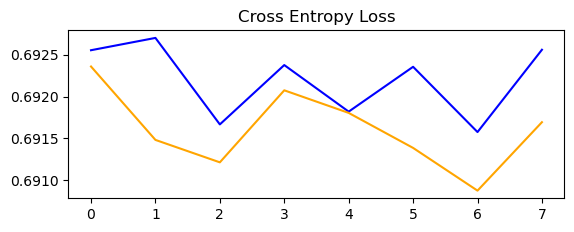

In [106]:
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')

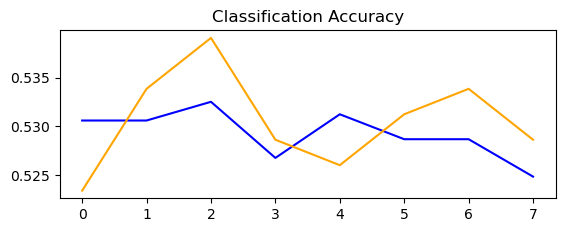

In [107]:
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['acc'], color='blue', label='train')
plt.plot(history.history['val_acc'], color='orange', label='val')

In [95]:
y_pred = custom_vgg_model.predict(real_test)
y_test = real_test.classes

1/1 [==============================] - 3s 3s/step


In [103]:
threshold = 0.6
pred = (y_pred > threshold).astype(int)

accuracy = (pred == y_test).mean()

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 59.09%
